<a href="https://colab.research.google.com/github/hyemin1826/clustering/blob/main/DTWD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install yfinance
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 


# 1. Make Data

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf

aapl = yf.download('AAPL', start="2020-01-01")
goog = yf.download('GOOG', start="2020-01-01")
o = yf.download('O', start="2020-01-01")
tsm = yf.download('TSM', start="2020-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
aapl['ticker'] = "AAPL"
goog['ticker'] = "GOOG"
o['ticker'] = "O"
tsm['ticker'] = "TSM"

data = pd.concat([aapl, goog, o, tsm], axis=0)
data['time'] = data.index

data.set_index(['time','ticker'], inplace=True)
data = data.sort_index()

time = data.index.get_level_values(0)
tickers = data.index.get_level_values(1).unique()

for t in time:
    if (data.xs(t).shape[0] != 4):
        data = data.drop(t, level=0)

data.head(4)

Open       High        Low      Close  Adj Close  \
time       ticker                                                          
2020-01-02 AAPL    74.059998  75.150002  73.797501  75.087502  73.683571   
           GOOG    67.077499  68.406998  67.077499  68.368500  68.368500   
           O       71.560081  71.705429  69.699615  70.232559  62.739418   
           TSM     59.599998  60.119999  59.599998  60.040001  56.990181   

                        Volume  
time       ticker               
2020-01-02 AAPL    135480400.0  
           GOOG     28132000.0  
           O         2061523.0  
           TSM       8432600.0

# 2. Caculate distance matrix D

In [9]:
def distance(x1, x2):
    """
    x1: p x 1, x2: p x 1
    Euclidean distance
    """
    x1 = np.transpose(x1) # 1 x p
    x2 = np.transpose(x2) # 1 x p

    temp = x1 - x2 # 1 x p
    return np.sqrt(np.dot(temp, temp.T))

In [10]:
def DTWDistance(x1, x2, bw):
    """
    x1: p X n, x2: p X m 
    p: the # of features, m: the # of times
    bw: bandwidth
    """
    n = x1.shape[1]
    m = x2.shape[1]

    D = np.zeros((n, m))
    
    D[0,0] = distance(x1[:, 0], x2[:, 0])
    print(f'D[0,0]:{D[0,0]}')

    for i in range(1, n):
        D[i, 0] = np.inf
    for j in range(1,m):
        D[0, j] = np.inf

    for i in range(1, n):
        for j in range(max(1, i-bw), min(m, i+bw)):
            cost = (distance(x1[:, i], x2[:, j]))/1000000
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    
    return D[n-1, m-1]

In [11]:
t1 = data.xs('AAPL', level=1).transpose().to_numpy()
t2 = data.xs('AAPL', level=1).transpose().to_numpy()

print(DTWDistance(t1, t2, 3))

D[0,0]:0.0
0.0


In [12]:
num_ticker = len(tickers)
total_D = np.zeros((num_ticker, num_ticker))

datas = [data.xs(ticker, level=1).transpose().to_numpy() for ticker in tickers]

In [13]:
for i in range(num_ticker):
    for j in range(num_ticker):
        if (total_D[j, i]!=0):
            total_D[i, j] = total_D[j, i]
            continue
        
        total_D[i, j] = DTWDistance(datas[i], datas[j], 3)

total_D

D[0,0]:0.0
D[0,0]:133418877.00000067
D[0,0]:26070477.0000014
D[0,0]:6371077.000040512
D[0,0]:0.0
D[0,0]:107348400.00000098
D[0,0]:127047800.0000045
D[0,0]:0.0
D[0,0]:19699400.000009626
D[0,0]:0.0


array([[  0.    , 173.2135,  43.5217,  28.7437],
       [173.2135,   0.    , 121.2587, 136.0367],
       [ 43.5217, 121.2587,   0.    ,  12.0507],
       [ 28.7437, 136.0367,  12.0507,   0.    ]])

# 3. Clustering

## 3-1. Test by library

### 1) Hierchial clustering

In [ ]:
import scipy.cluster.hierarchy as hcl
from scipy.spatial.distance import squareform

{'color_list': ['C1', 'C1', 'C0'],
 'dcoord': [[0.0, 9.624200002416302, 9.624200002416302, 0.0],
  [0.0, 40.01400000014606, 40.01400000014606, 9.624200002416302],
  [0.0, 113.27170000043571, 113.27170000043571, 40.01400000014606]],
 'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'ivl': ['1', '0', '2', '3'],
 'leaves': [1, 0, 2, 3],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1']}

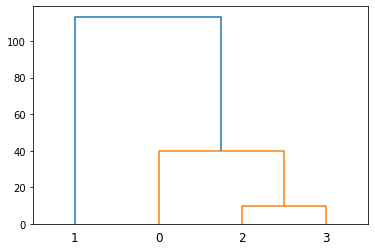

In [ ]:
hcl.dendrogram(hcl.linkage(squareform(total_D)))

### 2) K-Medoids

In [ ]:
from sklearn_extra.cluster import KMedoids

km = KMedoids(n_clusters=2, method='pam')
km.fit(total_D)

KMedoids(method='pam', n_clusters=2)

In [ ]:
km.labels_

array([1, 0, 1, 1])

## 3-2. Make own module

### 1) Hierchial

### 2) K-Medoids


In [76]:
total_D

array([[  0.    , 173.2135,  43.5217,  28.7437],
       [173.2135,   0.    , 121.2587, 136.0367],
       [ 43.5217, 121.2587,   0.    ,  12.0507],
       [ 28.7437, 136.0367,  12.0507,   0.    ]])

In [98]:
class KMedoids:
    def __init__(self, distance, k, tau):
        """
        distance: n X n matrix 
        n : the # of data
        """
        self.D = distance 
        self.n = self.D.shape[0]

        self.TD = np.inf
        
        self.num_cluster = k
        self.medoids = [-1 for i in range(self.num_cluster)]
        
        self.d_nearest = [-1 for i in range(self.n)]
        self.d_second = [-1 for i in range(self.n)]
        self.nearest_idx = [-1 for i in range(self.n)]

        self.tau = tau
        
    def _nearest_distance_to_medoids(self, o):
        # o: index of the data
        distance = np.inf
        for m in self.medoids:
            if (self.D[m, o] < distance): distance = self.D[m, o]

        return distance    

    def _compute_pam2_initial(self):  
        for i in range(self.n):
            temp_dist = [np.inf, np.inf] # container for nearest, second
            nearest_idx = -1
            for j in range(self.num_cluster): # 0, 1, ..., k-1
                m = self.medoids[j]
                if (self.D[i, m] < temp_dist[1]):
                    if (self.D[i, m] < temp_dist[0]):
                        temp_dist[1] = temp_dist[0]
                        temp_dist[0] = self.D[i, m]                  
                        nearest_idx = j
                    else:
                        temp_dist[1] = self.D[i,m]
                
            self.nearest_idx[i] = nearest_idx
            self.d_nearest[i] = temp_dist[0]
            self.d_second[i] = temp_dist[1]
        return

    def _build(self):
        TDs = [0 for i in range(self.n)]
        TD = np.inf

        for i in range(self.n):
            for j in range(self.n):
                if (j==i): continue
                TDs[i] += self.D[i, j]

            if (TDs[i] < TD): 
                TD = TDs[i]
                self.medoids[0] = i
        
        for i in range(1, self.num_cluster):
            delta_TD_opt = np.inf
            x_opt = None

            for j in range(self.n): # new medoids candidates
                if (j in self.medoids): continue
                delta_TD = 0
                for o in range(self.n):
                    if ((o in self.medoids) or (o==j)): continue
                    delta = self.D[j, o] - self._nearest_distance_to_medoids(o)
                    if (delta<0): delta_TD += delta
                if (delta_TD < delta_TD_opt): 
                    delta_TD_opt = delta_TD
                    x_opt = j
            self.TD += delta_TD_opt
            self.medoids[i] = x_opt

    def _delta_for_swap(self, x, ori_m_idx, new_m):
        if (ori_m_idx == self.nearest_idx[x]):
            return min(self.D[x, new_m], self.d_second[x]) - self.d_nearest[x]
        return min(self.D[x, new_m]-self.d_nearest[x], 0)

    def run(self):
        self._build() # initialize the medoids
        
        while (True):
            self._compute_pam2_initial() # calculate nearest, d_nearest, d_second
            delta_TDs_opt = [0 for i in range(self.num_cluster)]
            xs_opt = [-1 for i in range(self.num_cluster)]

            for i in range(self.n):
                if (i in self.medoids) : continue
                d_i = self.d_nearest[i]
                delta_TD = [-d_i for i in range(self.num_cluster)]

                for j in range(self.n):
                    if (i==j): continue
                    d_ij = self.D[i,j]
                    n, d_n, d_s = (self.nearest_idx[j], self.d_nearest[j], self.d_second[j])
                    
                    delta_TD[n] += min(d_ij, d_s) - d_n
                    if (d_ij < d_n): 
                        for m_idx in range(self.num_cluster):
                            if (m_idx == n): continue
                            delta_TD[m_idx] += d_ij - d_n
                
                for TD_idx in range(self.num_cluster):
                    if (delta_TD[TD_idx] < delta_TDs_opt[TD_idx]):
                        delta_TDs_opt[TD_idx], xs_opt[TD_idx] = (delta_TD[TD_idx], i)

            
            if min(delta_TDs_opt)>=0:
                break

            i = np.argmin(delta_TDs_opt) #m_i를 x*[i]로 swap 시 최적의 improvement 실현 가능
            while (delta_TDs_opt[i]<0): # when switch i-th medoid and non-mdeoid => effective
                # 1. swap medoids[i] <-> x*[i]
                self.medoids[i] = xs_opt[i]
                self._compute_pam2_initial()
                self.TD += delta_TDs_opt[i]
                delta_TDs_opt[i] = 0 # swap이 끝났으니 m[i] == x*[i] => 따라서 delta TD = 0

                for j in range(self.num_cluster):
                    if (delta_TDs_opt[j]>=0): continue

                    # delta_TDs_opt[ii] < 0 
                    delta_TD = 0 # m[j] -> x*[j] swap 시 change cost
                    for o in range(self.n):
                        if (o == self.medoids[j]):
                            delta_TD += self._delta_for_swap(o, j, xs_opt[j])
                        elif (o in self.medoids): continue
                        else:
                            delta_TD += self._delta_for_swap(o, j, xs_opt[j])

                    if (delta_TD <= self.tau*delta_TDs_opt[j]):
                        delta_TDs_opt[j] = delta_TD;
                    else:
                        delta_TDs_opt[j] = 0

                i = np.argmin(delta_TDs_opt)

  

In [100]:
model = KMedoids(total_D, 2, 0.5)
model.run()

In [102]:
model.nearest_idx

[0, 1, 0, 0]